<a href="https://colab.research.google.com/github/ariang/fs23ads/blob/main/NN_for_image_recognition_P2_(28_03_2023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks (CNN)

In [1]:
#as per Colab 1
%matplotlib inline 

## Python Modules

In [2]:
import numpy as np                   
import matplotlib.pyplot as plt      
import random                        # random number generators

import tensorflow as tf
import os 
from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Sequential models in Keras

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

In [3]:
# import some additional tools specifically for CNN

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten, BatchNormalization

## (Re)Loading the Data

We keep on playing with the MNIST data set.

In [ ]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Moving toward convolution. What is it?

Convolution requires a shift of paradigm.

The term convolution comes from mathematics and indicates a composition of functions.

Convolution applies **kernels** (i.e., filters) that scan through each image to generate the so-called **feature maps**. The network then learns these features, rather than the single pixels.

In other words, instead of directly feeding our network with the images in the form of normalized and flattened pixels, we transform the data via kernels, extracting characteristics like angles, curvatures, etc., which allow the network to indipendently learn the most relevant features that are important to classify an image.

In the example below, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix, i.e., $
\left[\begin{array}{ccc}
1 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 1
\end{array} \right].$

The kernel moves one pixel at a time, therefore, we say it has **stride** 1. In case the kernel jumps from pixel 1 to pixel 4, then we say that the stride is 3. And so on.

Another parameter of interest is **padding**. It is used to deal with the image borders. A padding value of 1 means that we add one 0 pixel all around the picture. A value of 2 corresponds to two 0 pixels all aroung.

For example, the matrix $\left[ \begin{array}{cccc}
1 & 1  \\ 2 & 4 
\end{array} \right]$ becomes $\left[ \begin{array}{cc}
0 & 0 & 0 &0 \\ 0 & 1 & 1 & 0  \\ 0& 2 & 4 &0 \\0 & 0 & 0 &0
\end{array} \right]$ with a padding value of 1.

The case of no padding is also known as *valid*. With *same*, one indicates that the value of padding is defined to guarantee that the convolved matrix has the same dimensions of the original data (without padding).

**A filtering example, no padding**

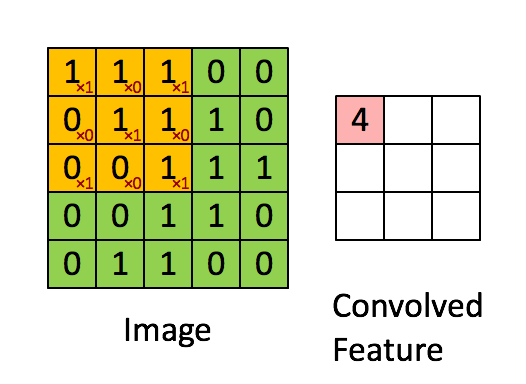

<sub><sup>Picture by [Yash Katariya](https://github.com/yashk2810/MNIST-Keras).<sub><sup>

A dot product operation takes place between the image and the kernel and the convolved feature is generated. For instance, the first value $4$ in the convolved feature is obtained by the dot product
$$
\left[\begin{array}{ccc}
1 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 1
\end{array} \right] \cdot
\left[\begin{array}{ccc}
1 & 1 & 1 \\ 0 & 1 & 1 \\ 0 & 0 & 1
\end{array} \right] =1+0+1+0+1+0+0+0+1=4 .
$$
Regarding the number 3, we have (notice that the second matrix changes)
$$
\left[\begin{array}{ccc}
1 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 1
\end{array} \right] \cdot
\left[\begin{array}{ccc}
1 & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 1
\end{array} \right] =1+0+0+0+1+0+0+0+1=3,
$$
and so on.

Each kernel in a convolutional neural network learns a different characteristic of an image.

**Exercise:** obtain all the other values in the convolved matrix.


There are many kernels available. They are commonly used in photography and photo editing to blurr, sharpen, change color, etc.

Just as an example, have a look at [these kernels from Wikipedia](https://en.wikipedia.org/wiki/Kernel_(image_processing)).

Sharpening kernel: $\begin{bmatrix}
\ \ 0 & -1 & \ \ 0 \\
-1 & \ \ 5 & -1 \\
\ \ 0 & -1 & \ \ 0
\end{bmatrix}$

Blurring kernel: $\begin{bmatrix}
\ \ 1/9 &\ \  1/9 &\ \  1/9 \\
\ \ 1/9 &\ \  1/9 &\ \  1/9 \\
\ \ 1/9 &\ \  1/9 &\ \  1/9
\end{bmatrix}$


In machine learning networks kernels are used in a similar way, that is, for highlighting some characteristic of the image. 

Why do we do this?

Using kernels, and combining them with the so-called **pooling** techniques, we can reduce the dimensionality of the problem to be analyzed by our network. In fact, the network will only be trained on the most relevant features, and not on every single pixel.

In **max pooling**, for specifically defined sub-matrices, we only select the maximum values. For instance, assume that the we apply $2\times2$ max pooling to the following convolved matrix
$$
\left[\begin{array}{cccc}
10 & 2 & 12 & 0 \\ 25 & 3 & 0 & 8 \\ 1 & 0 & 1 & 9 \\ 16 & 4 & 4 & 7
\end{array} \right].
$$
What we get is

$$
\left[\begin{array}{cc}
25 & 12 \\ 16 & 9 
\end{array} \right].
$$

This reduces the number of parameters to be estimated and thus the computational burden.

An alternative is **average pooling**: the max is substituted by the average of each sub-matrix, so that we get (when using $2\times2$ pooling)
$$
\left[\begin{array}{cc}
10 & 5 \\ 5.25 & 5.25 
\end{array} \right].
$$


**Important:** we can build convolutions of convolutions, or convolutions of convolutions of convolutions, and so on. It all depends on the initial quality of the image in terms of pixels, because at every step we "lose" definition. For our human high some deep convolutions may become unrecognizable. 

**Hint:** Better stacking 2 layers with filter 3x3 than 1 layer with 5x5. Why?
Less parameters, less overfit, lower computational costs.

## A Deep Convolutional Neural Network

As before, we prepare our data, by rescaling, and by applying the one-hot format.

But we do **not flatten the input data**, as we first need to perform convolutions!

In [ ]:
X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255


In [ ]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

We can now build our network.

In [ ]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3 (so a proper deep network)
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6 (output)                      
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_5 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 24, 24, 32)       

In [ ]:
# we'll use the same optimizer as before (Colab 1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Data augmentation

Data augmentation is the process of artificially increasing the amount of data by generating new data points from existing data. 

This includes resampling observations, adding minor alterations to data or using machine learning models to generate new data points in the latent space of the original data to amplify the dataset.

The goal of data augmentation is to prevent overfitting, as much as possible.

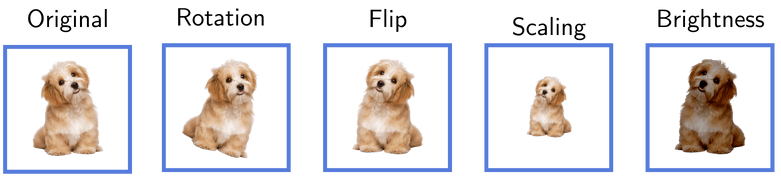

<sub><sup>Picture by [Saulo Barreto](https://www.baeldung.com/cs/author/saulocardoso)<sub><sup>

In *keras* augmenting data is quite simple.

In [ ]:
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
test_gen = ImageDataGenerator()

In [ ]:
# We can then feed our augmented data in batches
# Besides loss function considerations as before, this method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before, the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [ ]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit(train_generator, steps_per_epoch=60000//128, epochs=3, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128) 
# at home try epochs>=10

Epoch 1/3
468/468 [==============================] - 221s 465ms/step - loss: 0.1316 - accuracy: 0.9591 - val_loss: 0.0674 - val_accuracy: 0.9813
Epoch 2/3
468/468 [==============================] - 216s 462ms/step - loss: 0.0486 - accuracy: 0.9846 - val_loss: 0.0371 - val_accuracy: 0.9886
Epoch 3/3
468/468 [==============================] - 222s 474ms/step - loss: 0.0403 - accuracy: 0.9877 - val_loss: 0.0380 - val_accuracy: 0.9878


In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 11s 35ms/step - loss: 0.0379 - accuracy: 0.9878
Test score: 0.03791907802224159
Test accuracy: 0.9878000020980835


In [ ]:
# If you want to inspect the weights of your CNN
weights = model.get_weights()
# weights

## Exercise for you: experiment with the network.
1. Play with the different parameters and hyper-parameters.
2. Change the activation functions.
3. Add or remove layers.
4. Optional: try some famous architectures. Notice that we used something similar to LeNet-5.

In [ ]:
#@title Possible Answers 1-3

# Given all the combinations, it is not possible to give a unique answer.
# What you should notice is that the network can be quite sensitive to changes in
# the hyperparameters, while the activation function, with this kind of data, is less
# relevant for the results (if we ignore the impact on the computational burden).

In [ ]:
#@title Possible Answer 4

# Play with the basic settings of our network.

#model = keras.Sequential()
#model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
#model.add(layers.AveragePooling2D())
#model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
#model.add(layers.AveragePooling2D())
#model.add(layers.Flatten())
#model.add(layers.Dense(units=120, activation='relu'))
#model.add(layers.Dense(units=84, activation='relu'))
#model.add(layers.Dense(units=10, activation = 'softmax'))

# Any interesting improvement?

# CIFAR10, another intersting dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 


More info [here](https://www.cs.toronto.edu/~kriz/cifar.html).


In [ ]:
# Let us load the data set
cifar = tf.keras.datasets.cifar10

(train_full_images, train_full_labels), (test_images, test_labels) = cifar.load_data()

valid_images, train_images = train_full_images[:5000], train_full_images[5000:]
valid_labels, train_labels = train_full_labels[:5000], train_full_labels[5000:]
test_images = test_images 

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Let us have a look.

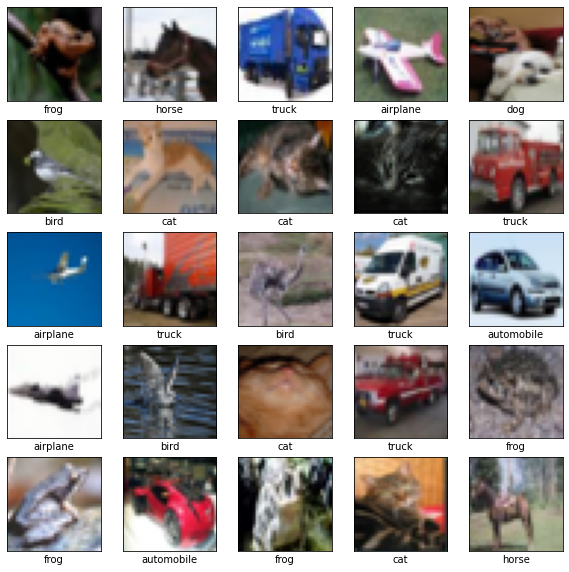

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Some properties of the data:

In [ ]:
print('training ds shape:', train_images.shape)
print('validation ds shape:', valid_images.shape)
print('test ds shape:', test_images.shape)

training ds shape: (45000, 32, 32, 3)
validation ds shape: (5000, 32, 32, 3)
test ds shape: (10000, 32, 32, 3)


As usual, we normalize

In [ ]:
train_images = train_images / 255.0
valid_images = valid_images / 255.0
test_images = test_images / 255.0

## Exercise for you: Build a network with 2 hidden layers and fit it

Some hints:
* Flatten the images.
* Add a first HL with 128 units and relu activation.
* To inizialize, try to use *he_normal*. Check the [help guide](https://www.tensorflow.org/api_docs/python/tf/keras/initializers).
* Add a second HL with relu activation and L2 refgularization with l=0.01.
* Use dropout regularization with a rate of 0.2.
* In the final layer, choose a softmax activation, as before.
* Use the *sgd* optimizer. Check the [help guide](https://keras.io/api/optimizers/).
* For the loss function, use the so-called Sparse Categorical Crossentropy, with *loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)*. The option *(from_logits=False)* is necessary given the presence of the softmax activation in the output layer. Check the [help guide](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy).

Feel free to amend some parts, but keep 2 hidden layers.

In [ ]:
#@title Possible solution: Network
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer = tf.keras.initializers.he_normal),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))

Epoch 1/10
1407/1407 [==============================] - 11s 7ms/step - loss: 2.6536 - accuracy: 0.2823 - val_loss: 2.3397 - val_accuracy: 0.3410
Epoch 2/10
1407/1407 [==============================] - 9s 6ms/step - loss: 2.2067 - accuracy: 0.3514 - val_loss: 2.0324 - val_accuracy: 0.3808
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.9886 - accuracy: 0.3745 - val_loss: 1.9175 - val_accuracy: 0.3808
Epoch 4/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.8557 - accuracy: 0.3932 - val_loss: 1.8397 - val_accuracy: 0.3872
Epoch 5/10
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7737 - accuracy: 0.4082 - val_loss: 1.7180 - val_accuracy: 0.4146
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7161 - accuracy: 0.4175 - val_loss: 1.6888 - val_accuracy: 0.4206
Epoch 7/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6734 - accuracy: 0.4282 - val_loss: 1.6447 - val_accurac

What are the performances of your network in terms of accuracy on the test data?

In [ ]:
#@title Possible solution: Accuracy
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1)
print('\nTest accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 1.6060 - accuracy: 0.4447

Test accuracy: 0.4447000026702881


## A CNN for CIFAR10

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), #beta_1 is 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

What type of network are we building? Let us have a look at the model.

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 flatten_5 (Flatten)         (None, 4096)             

Notice that this new models DOES NOT flatten data immediately (as the one you have created yourself). Why?

In [ ]:
model2.fit(train_images, train_labels, epochs=5, validation_data=(valid_images, valid_labels)) #at home try at least 10 epochs

Epoch 1/5
1407/1407 [==============================] - 119s 85ms/step - loss: 0.2721 - accuracy: 0.9017 - val_loss: 1.0871 - val_accuracy: 0.7112
Epoch 2/5
1407/1407 [==============================] - 119s 85ms/step - loss: 0.2453 - accuracy: 0.9132 - val_loss: 1.2391 - val_accuracy: 0.7046
Epoch 3/5
1407/1407 [==============================] - 121s 86ms/step - loss: 0.2197 - accuracy: 0.9219 - val_loss: 1.2907 - val_accuracy: 0.7176
Epoch 4/5
1407/1407 [==============================] - 123s 88ms/step - loss: 0.1982 - accuracy: 0.9290 - val_loss: 1.3732 - val_accuracy: 0.7074
Epoch 5/5
1407/1407 [==============================] - 119s 85ms/step - loss: 0.1811 - accuracy: 0.9362 - val_loss: 1.4648 - val_accuracy: 0.7100


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[int(true_label)].set_color('blue')

In [ ]:
predictions = model2.predict(test_images)

313/313 [==============================] - 7s 22ms/step


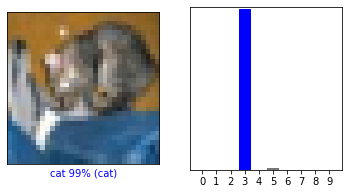

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

## Exercise for you: verify whether the model works

In [ ]:
image_url = 'https://res.cloudinary.com/dk-find-out/image/upload/q_80,w_1920,f_auto/DCTM_Penguin_UK_DK_AL697473_RGB_PNG_namnse.jpg' 
# you can choose your own image
image_url = tf.keras.utils.get_file('Court', origin=image_url)
img = tf.keras.preprocessing.image.load_img( image_url, target_size=(32, 32))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it is the only member.


predictions = model2.predict(img_array)
score = predictions[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 31ms/step
This image most likely belongs to dog with a 100.00 percent confidence.


How does the classification changes, by allowing more epochs?